In [1]:
from datasets import load_dataset 

# this dataset uses the new Image feature :)
dataset = load_dataset("arvindrajan92/sroie_document_understanding")

Using custom data configuration arvindrajan92--sroie_document_understanding-e255957fa0e974eb
Found cached dataset parquet (C:/Users/Lin Zeyin/.cache/huggingface/datasets/arvindrajan92___parquet/arvindrajan92--sroie_document_understanding-e255957fa0e974eb/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
dataset['train']

Dataset({
    features: ['image', 'ocr'],
    num_rows: 652
})

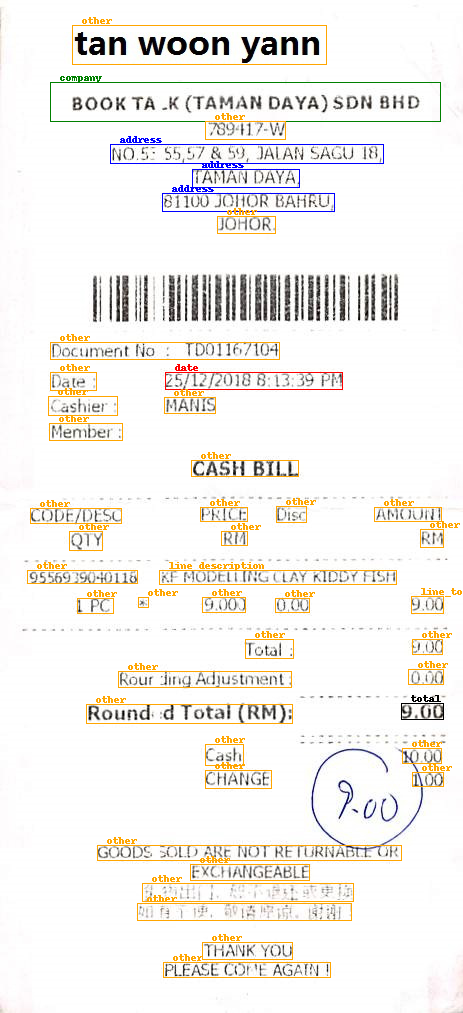

In [3]:
example = dataset['train'][0]
words = []
bboxes = []
labels = []

for dic in example['ocr']:
    p1, p2, p3, p4 = dic['box']
    label = dic['label']
    word = dic['text']
    words.append(word)
    bboxes.append(p1 + p3)
    labels.append(label)
    
from PIL import Image, ImageDraw, ImageFont

image = example['image']
#image = Image.open(image_path).convert("RGB") # 都可以

draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

label2color ={
    "address": 'blue',
    "company": 'green',
    "date": 'red',
    "total": 'black',
    "line_total": 'orange',
    "line_description": 'orange',
    "other": 'orange'
  } 
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

# width, height = example.page_size
# true_boxes = [unnormalize_box(box, width, height) for box in example.boxes]

# for label, box in zip(example.labels, true_boxes):
#     draw.rectangle(box, outline=label2color[label])
#     draw.text((box[0] + 10, box[1] - 10), text=label, fill=label2color[label], font=font)

for label, box in zip(labels, bboxes):
    draw.rectangle(box, outline=label2color[label])
    draw.text((box[0] + 10, box[1] - 10), text=label, fill=label2color[label], font=font)


image

In [4]:
#train

In [5]:
dataset['train'].features

{'image': Image(decode=True, id=None),
 'ocr': [{'box': Sequence(feature=Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), length=-1, id=None),
   'label': Value(dtype='string', id=None),
   'text': Value(dtype='string', id=None)}]}

In [6]:
from transformers import AutoProcessor, AutoModelForTokenClassification
from datasets import load_dataset

processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [7]:
image.size

(463, 1013)

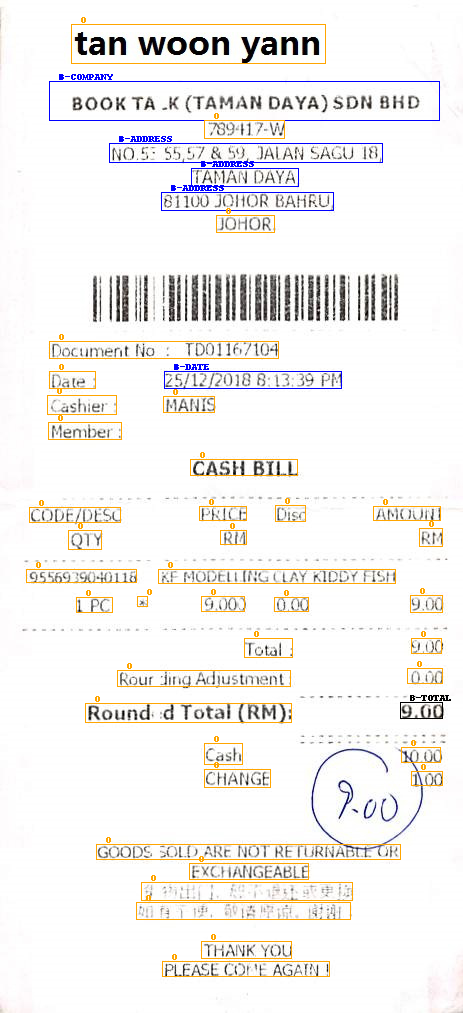

In [8]:
label2color ={
    "B-ADDRESS": 'blue',
    "I-ADDRESS": 'blue',
    "B-COMPANY": 'blue',
    "I-COMPANY": 'blue',  
    "B-DATE": 'blue',
    "I-DATE": 'blue',
    "B-TOTAL": 'black',
    "I-TOTAL": 'black',
    "O": 'orange'
  } 
label_list = [k for k in label2color.keys()]
label_list
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}

example = dataset['train'][0]

def convert_example_features(example):
    words = []
    bboxes = []
    labels = []
    image = example['image']
    for dic in example['ocr']:
        prefix_B = True
        p1, p2, p3, p4 = dic['box']
        label = dic['label']
        word = dic['text']
        split_tokens = word.split()
        for token in split_tokens:
            words.append(token)
            bboxes.append(p1 + p3)
            if label != 'other' and label != 'line_total' and label != 'line_description':
                if prefix_B:
                    labels.append('B-' + label.upper())
                    prefix_B = False
                else:
                    labels.append('I-' + label.upper())
            else:
                labels.append('O')
    width, height = image.size
    normalized_bboxes = [normalize_box(box, width, height) for box in bboxes]
    label_ids = [label2id[label] for label in labels]
    return image, words, normalized_bboxes, label_ids

def normalize_box(bbox, width, height):
    return [
        int((bbox[0] * 1000) / width),
        int((bbox[1] * 1000) / height),
        int((bbox[2] * 1000) / width),
        int((bbox[3] * 1000) / height),
    ]
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

image, words, normalized_bboxes, label_ids = convert_example_features(example)

# 可视化证明上面生成的四个变量正确
unnormalize_bboxes = [unnormalize_box(box, image.size[0], image.size[1]) for box in normalized_bboxes]

from PIL import Image, ImageDraw, ImageFont

draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

label2color ={
    "B-ADDRESS": 'blue',
    "I-ADDRESS": 'blue',
    "B-COMPANY": 'green',
    "I-COMPANY": 'green',  
    "B-DATE": 'pink',
    "I-DATE": 'pink',
    "B-TOTAL": 'black',
    "I-TOTAL": 'black',
    "O": 'orange'
  } 
for lid, box in zip(label_ids, unnormalize_bboxes):
    draw.rectangle(box, outline=label2color[id2label[lid]])
    draw.text((box[0] + 10, box[1] - 10), text=id2label[lid], fill=label2color[id2label[lid]], font=font)
image

In [9]:
print(len(words), len(normalized_bboxes), len(label_ids)) #,image

label_list = [k for k in label2color.keys()]
label_list
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}

85 85 85


In [10]:
model = AutoModelForTokenClassification.from_pretrained("microsoft/layoutlmv3-base", num_labels=len(label_list))

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
image, words, normalized_bboxes, label_ids

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=463x1013>,
 ['TAN',
  'WOON',
  'YANN',
  'BOOK',
  'TA',
  '.K(TAMAN',
  'DAYA)',
  'SDN',
  'BHD',
  '789417-W',
  'NO.53',
  '55,57',
  '&',
  '59,',
  'JALAN',
  'SAGU',
  '18,',
  'TAMAN',
  'DAYA,',
  '81100',
  'JOHOR',
  'BAHRU,',
  'JOHOR.',
  'DOCUMENT',
  'NO',
  ':',
  'TD01167104',
  'DATE:',
  '25/12/2018',
  '8:13:39',
  'PM',
  'CASHIER:',
  'MANIS',
  'MEMBER:',
  'CASH',
  'BILL',
  'CODE/DESC',
  'PRICE',
  'DISC',
  'AMOUNT',
  'QTY',
  'RM',
  'RM',
  '9556939040116',
  'KF',
  'MODELLING',
  'CLAY',
  'KIDDY',
  'FISH',
  '1',
  'PC',
  '*',
  '9.000',
  '0.00',
  '9.00',
  'TOTAL:',
  'ROUR',
  'DING',
  'ADJUSTMENT:',
  '0.00',
  'ROUND',
  'D',
  'TOTAL',
  '(RM):',
  '9.00',
  'CASH',
  '10.00',
  'CHANGE',
  '1.00',
  'GOODS',
  'SOLD',
  'ARE',
  'NOT',
  'RETURNABLE',
  'OR',
  'EXCHANGEABLE',
  '***',
  '***',
  'THANK',
  'YOU',
  'PLEASE',
  'COME',
  'AGAIN',
  '!',
  '9.00'],
 [[155, 24, 704, 63],

In [12]:
encoding = processor(image, words, boxes=normalized_bboxes, word_labels=label_ids,
                     truncation=True, padding="max_length",
                     return_tensors="pt", 
                     return_offsets_mapping=True,
                    )
offset_mapping = encoding.pop('offset_mapping') # 推理使用

# import torch
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# for k,v in encoding.items():
#     encoding[k] = v.to(device)
    
outputs = model(**encoding)
logits = outputs.logits
predictions = logits.argmax(-1).squeeze().tolist()
print(len(predictions))

# 只保留开头的wordpiece的label
import numpy as np
is_subword = []
for a, b in offset_mapping.squeeze().tolist():
    if a == 0 and b != 0:
        is_subword.append(False)
    else:
        is_subword.append(True)
true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
print(len(true_predictions))

C:\Users\Lin Zeyin\anaconda3\envs\Deep-Learning\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


512
85


In [13]:
new_SROIE = []
fid = 1
for example in dataset['train']:
    image, words, normalized_bboxes, label_ids = convert_example_features(example)
    #image.save('./new_SROIE_train_data/' + f'{fid}.jpg')
    new_example = {
        'fid': fid,
        'tokens': words,
        'bboxes': normalized_bboxes,
        'label_ids': label_ids,
        'image_path': './new_SROIE_train_data/' + f'{fid}.jpg'
    }
    new_SROIE.append(new_example)
    fid += 1

In [14]:
from datasets import Dataset
new_SROIE_dataset = Dataset.from_list(new_SROIE)

In [15]:
new_SROIE_dataset[0]

{'fid': 1,
 'tokens': ['TAN',
  'WOON',
  'YANN',
  'BOOK',
  'TA',
  '.K(TAMAN',
  'DAYA)',
  'SDN',
  'BHD',
  '789417-W',
  'NO.53',
  '55,57',
  '&',
  '59,',
  'JALAN',
  'SAGU',
  '18,',
  'TAMAN',
  'DAYA,',
  '81100',
  'JOHOR',
  'BAHRU,',
  'JOHOR.',
  'DOCUMENT',
  'NO',
  ':',
  'TD01167104',
  'DATE:',
  '25/12/2018',
  '8:13:39',
  'PM',
  'CASHIER:',
  'MANIS',
  'MEMBER:',
  'CASH',
  'BILL',
  'CODE/DESC',
  'PRICE',
  'DISC',
  'AMOUNT',
  'QTY',
  'RM',
  'RM',
  '9556939040116',
  'KF',
  'MODELLING',
  'CLAY',
  'KIDDY',
  'FISH',
  '1',
  'PC',
  '*',
  '9.000',
  '0.00',
  '9.00',
  'TOTAL:',
  'ROUR',
  'DING',
  'ADJUSTMENT:',
  '0.00',
  'ROUND',
  'D',
  'TOTAL',
  '(RM):',
  '9.00',
  'CASH',
  '10.00',
  'CHANGE',
  '1.00',
  'GOODS',
  'SOLD',
  'ARE',
  'NOT',
  'RETURNABLE',
  'OR',
  'EXCHANGEABLE',
  '***',
  '***',
  'THANK',
  'YOU',
  'PLEASE',
  'COME',
  'AGAIN',
  '!',
  '9.00'],
 'bboxes': [[155, 24, 704, 63],
  [155, 24, 704, 63],
  [155, 24, 7

In [16]:
def prepare_examples(examples):
    images = [Image.open(path).convert("RGB") for path in examples['image_path']] #Image.open(examples[image_column_name])
    words = examples['tokens']
    boxes = examples['bboxes']
    word_labels = examples['label_ids']

    encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

    return encoding
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = new_SROIE_dataset.map(
    prepare_examples,
    batched=True,
    remove_columns=new_SROIE_dataset.column_names,
    features=features,
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [21]:
train_dataset.set_format("torch")
for k, v in train_dataset[0].items():
    print(k, v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [22]:
split_dataset = train_dataset.train_test_split(test_size=0.1)

In [23]:
train_dataset = split_dataset['train']
eval_dataset = split_dataset['test']

In [24]:
train_dataset, eval_dataset

(Dataset({
     features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
     num_rows: 527
 }),
 Dataset({
     features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
     num_rows: 59
 }))

In [25]:
from datasets import load_metric

metric = load_metric("seqeval")

C:\Users\LINZEY~1\AppData\Local\Temp/ipykernel_38972/3097260500.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [46]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [59]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="layoutlmv3-finetuned-sroie",
                                  max_steps=2000,
                                  per_device_train_batch_size=1,
                                  per_device_eval_batch_size=1,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  )

from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs


In [60]:
trainer.train()

***** Running training *****
  Num examples = 527
  Num Epochs = 4
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 2000
  Number of trainable parameters = 125333897


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.194825,0.674912,0.566766,0.616129,0.952903
200,No log,0.071022,0.882736,0.804154,0.841615,0.980364
300,No log,0.073875,0.805627,0.934718,0.865385,0.981787
400,No log,0.077684,0.888235,0.896142,0.892171,0.983495
500,0.183900,0.058926,0.907246,0.928783,0.917889,0.986340
600,0.183900,0.054165,0.944282,0.955490,0.949853,0.990609
700,0.183900,0.054115,0.927536,0.949555,0.938416,0.988902
800,0.183900,0.040191,0.975684,0.952522,0.963964,0.993455
900,0.183900,0.035407,0.934286,0.970326,0.951965,0.992032
1000,0.038600,0.051698,0.961652,0.967359,0.964497,0.992743


***** Running Evaluation *****
  Num examples = 59
  Batch size = 1
C:\Users\Lin Zeyin\anaconda3\envs\Deep-Learning\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
***** Running Evaluation *****
  Num examples = 59
  Batch size = 1
***** Running Evaluation *****
  Num examples = 59
  Batch size = 1
***** Running Evaluation *****
  Num examples = 59
  Batch size = 1
***** Running Evaluation *****
  Num examples = 59
  Batch size = 1
Saving model checkpoint to layoutlmv3-finetuned-sroie\checkpoint-500
Configuration saved in layoutlmv3-finetuned-sroie\checkpoint-500\config.json
Model weights saved in layoutlmv3-finetuned-sroie\checkpoint-500\pytorch_model.bin
Image processor saved in layoutlmv3-finetuned-sroie\checkpoint-500\preprocessor_config.json
tokenizer config

KeyboardInterrupt: 

In [61]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 59
  Batch size = 1


{'eval_loss': 0.048904530704021454,
 'eval_precision': 0.9642857142857143,
 'eval_recall': 0.9614243323442137,
 'eval_f1': 0.962852897473997,
 'eval_accuracy': 0.9934547524188958}

In [62]:
from transformers import AutoModelForTokenClassification

my_model = AutoModelForTokenClassification.from_pretrained("./layoutlmv3-finetuned-sroie/checkpoint-1000")#/content/layoutlmv3-finetuned-invoice/checkpoint-2000

loading configuration file ./layoutlmv3-finetuned-sroie/checkpoint-1000\config.json
Model config LayoutLMv3Config {
  "_name_or_path": "./layoutlmv3-finetuned-sroie/checkpoint-1000",
  "architectures": [
    "LayoutLMv3ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "input_size": 224,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
 

dict_keys(['fid', 'tokens', 'bboxes', 'label_ids', 'image_path'])
input_ids torch.Size([1, 335])
attention_mask torch.Size([1, 335])
bbox torch.Size([1, 335, 4])
labels torch.Size([1, 335])
pixel_values torch.Size([1, 3, 224, 224])
torch.Size([1, 335, 9])
335 335
predict 123 tokens


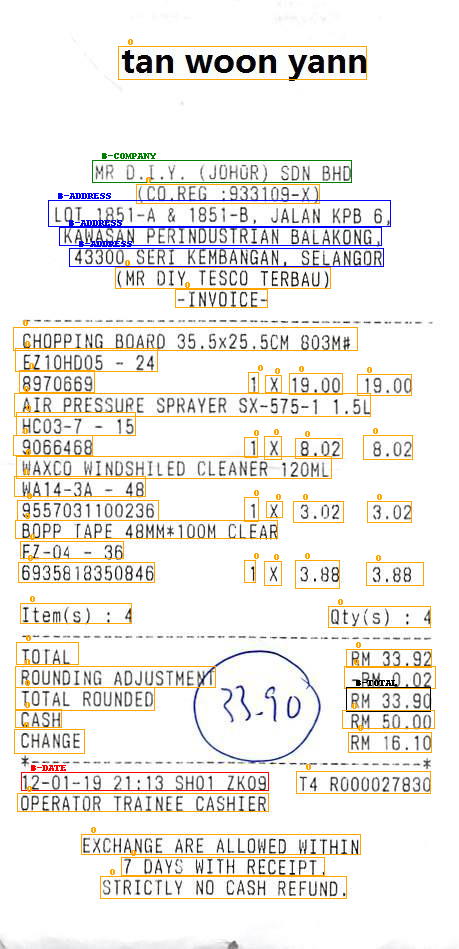

In [121]:
# inference
inference_example = new_SROIE_dataset[2]
print(inference_example.keys())

image = Image.open(inference_example["image_path"])
words = inference_example["tokens"]
boxes = inference_example["bboxes"]
word_labels = inference_example["label_ids"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
    print(k,v.shape)
    
with torch.no_grad():
    outputs = my_model(**encoding)

logits = outputs.logits
print(logits.shape)

predictions = logits.argmax(-1).squeeze().tolist()
labels = encoding.labels.squeeze().tolist()

print(len(predictions), len(labels))

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

label2color ={
    "B-ADDRESS": 'blue',
    "I-ADDRESS": 'blue',
    "B-COMPANY": 'green',
    "I-COMPANY": 'green',  
    "B-DATE": 'red',
    "I-DATE": 'red',
    "B-TOTAL": 'black',
    "I-TOTAL": 'black',
    "O": 'orange'
  } 

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = prediction
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

print(f'predict {len(true_predictions)} tokens')
image

draw 123 tokens


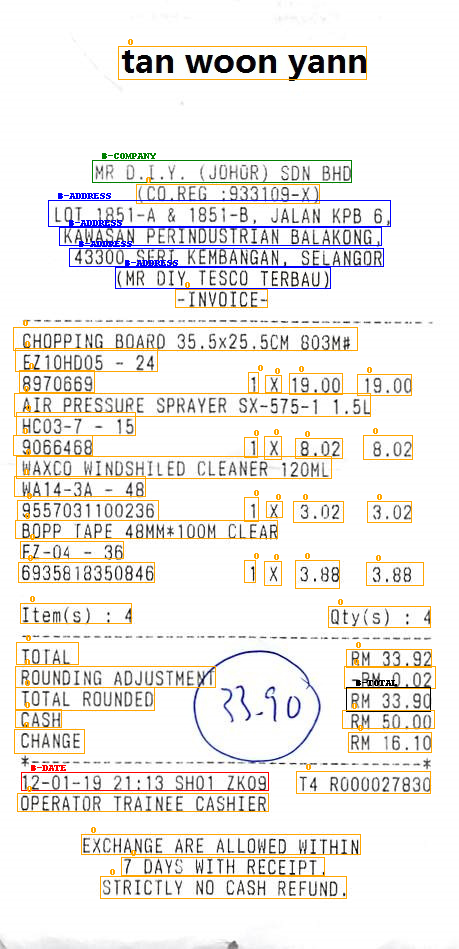

In [122]:
# groung truth
label2color ={
    "B-ADDRESS": 'blue',
    "I-ADDRESS": 'blue',
    "B-COMPANY": 'blue',
    "I-COMPANY": 'blue',  
    "B-DATE": 'blue',
    "I-DATE": 'blue',
    "B-TOTAL": 'black',
    "I-TOTAL": 'black',
    "O": 'orange'
  } 
label_list = [k for k in label2color.keys()]
label_list
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}

example = dataset['train'][2]

def convert_example_features(example):
    words = []
    bboxes = []
    labels = []
    image = example['image']
    for dic in example['ocr']:
        prefix_B = True
        p1, p2, p3, p4 = dic['box']
        label = dic['label']
        word = dic['text']
        split_tokens = word.split()
        for token in split_tokens:
            words.append(token)
            bboxes.append(p1 + p3)
            if label != 'other' and label != 'line_total' and label != 'line_description':
                if prefix_B:
                    labels.append('B-' + label.upper())
                    prefix_B = False
                else:
                    labels.append('I-' + label.upper())
            else:
                labels.append('O')
    width, height = image.size
    normalized_bboxes = [normalize_box(box, width, height) for box in bboxes]
    label_ids = [label2id[label] for label in labels]
    return image, words, normalized_bboxes, label_ids

def normalize_box(bbox, width, height):
    return [
        int((bbox[0] * 1000) / width),
        int((bbox[1] * 1000) / height),
        int((bbox[2] * 1000) / width),
        int((bbox[3] * 1000) / height),
    ]
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

image, words, normalized_bboxes, label_ids = convert_example_features(example)

# 可视化证明上面生成的四个变量正确
unnormalize_bboxes = [unnormalize_box(box, image.size[0], image.size[1]) for box in normalized_bboxes]

from PIL import Image, ImageDraw, ImageFont

draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

label2color ={
    "B-ADDRESS": 'blue',
    "I-ADDRESS": 'blue',
    "B-COMPANY": 'green',
    "I-COMPANY": 'green',  
    "B-DATE": 'red',
    "I-DATE": 'red',
    "B-TOTAL": 'black',
    "I-TOTAL": 'black',
    "O": 'orange'
  }
for lid, box in zip(label_ids, unnormalize_bboxes):
    draw.rectangle(box, outline=label2color[id2label[lid]])
    draw.text((box[0] + 10, box[1] - 10), text=id2label[lid], fill=label2color[id2label[lid]], font=font)
image

print(f'draw {len(words)} tokens')
image

In [170]:
# inference more data 
eval_image_path = './archive/SROIE2019/test/img/'
eval_bbox_path = './archive/SROIE2019/test/box/'
csv_path = './output.csv'

In [223]:
import os
import csv
from PIL import Image, ImageDraw, ImageFont
for img_file_name in os.listdir(eval_image_path):
    fid = img_file_name.split('.jpg')[0]
    print('='*30)
    print('Processing file', fid)
    bbox_file_name = fid + '.txt'
    f = open(eval_bbox_path + bbox_file_name)
    
    bboxes = []
    tokens = []
    
    for row in f:
        #print(row.strip().split(','))
        split_row = row.strip().split(',')
        if len(split_row) <  8:
            continue
        x0, y0, x1, y1, x2, y2, x3, y3 = split_row[0:8]
        bbox = [int(x0), int(y0), int(x2), int(y2)]
        words = ",".join(split_row[8:])
        #print(bbox, words)
        for word in words.split(' '):
            if word != ' ' and word != '':
                tokens.append(word)
                bboxes.append(bbox)
    
    
    # 可视化
    image = Image.open(eval_image_path + img_file_name).convert("RGB")
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    for box in bboxes:
        draw.rectangle(box, outline='black')
    #image.show()
    print(f'There are {len(tokens)} tokens need to predict:')
    
    # inference 
    
    def normalize_box(bbox, width, height):
        return [
            int((bbox[0] * 1000) / width),
            int((bbox[1] * 1000) / height),
            int((bbox[2] * 1000) / width),
            int((bbox[3] * 1000) / height),
        ]
    width, height = image.size
    normalized_bboxes = [normalize_box(box, width, height) for box in bboxes]
    
    encoding = processor(image, tokens, boxes=normalized_bboxes,
                     truncation=True, padding="max_length",
                     return_tensors="pt", 
                     return_offsets_mapping=True,
                    )
    offset_mapping = encoding.pop('offset_mapping') # 推理使用

    # import torch
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # for k,v in encoding.items():
    #     encoding[k] = v.to(device)

    outputs = my_model(**encoding)
    logits = outputs.logits
    predictions = logits.argmax(-1).squeeze().tolist()
    #print(len(predictions)) 512

    # 只保留开头的wordpiece的label
    
    import numpy as np
    is_subword = []
    for a, b in offset_mapping.squeeze().tolist():
        if a == 0 and b != 0:
            is_subword.append(False)
        else:
            is_subword.append(True)
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
    
    # 检验
    #assert len(true_predictions) == len(tokens) # 有可能超过512的seq限制
    
    # 推理结果可视化
    image = Image.open(eval_image_path + img_file_name).convert("RGB")
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    for prediction, box in zip(true_predictions, bboxes):
        predicted_label = prediction
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

    image.save('./sroie_inference_data/' + img_file_name)
    print(f'Successfully predict {len(true_predictions)} tokens')
    
    # 写入结果
    with open(csv_path, 'a', encoding='UTF8', newline='') as fc:
        # 创建CSV写入器
        writer = csv.writer(fc)
        for i in range(len(tokens)):
            if i < len(true_predictions):
                unformat_label = true_predictions[i]
                if unformat_label == 'O':
                    format_label = 'O'
                else:
                    format_label = 'S-' + unformat_label.split('-')[-1]

                row = [tokens[i], format_label, fid]
                # 向CSV文件写入一行
                writer.writerow(row)
            else:
                row = [tokens[i], 'O', fid]
        writer.writerow([])
    print('Writing result done')

Processing file X00016469670
There are 111 tokens need to predict:


C:\Users\Lin Zeyin\anaconda3\envs\Deep-Learning\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Successfully predict 111 tokens
Writing result done
Processing file X00016469671
There are 94 tokens need to predict:
Successfully predict 94 tokens
Writing result done
Processing file X51005200931
There are 150 tokens need to predict:
Successfully predict 150 tokens
Writing result done
Processing file X51005230605
There are 90 tokens need to predict:
Successfully predict 90 tokens
Writing result done
Processing file X51005230616
There are 132 tokens need to predict:
Successfully predict 132 tokens
Writing result done
Processing file X51005230621
There are 110 tokens need to predict:
Successfully predict 110 tokens
Writing result done
Processing file X51005230648
There are 108 tokens need to predict:
Successfully predict 108 tokens
Writing result done
Processing file X51005230657
There are 137 tokens need to predict:
Successfully predict 137 tokens
Writing result done
Processing file X51005230659
There are 81 tokens need to predict:
Successfully predict 81 tokens
Writing result done
Pr

Successfully predict 187 tokens
Writing result done
Processing file X51005663274
There are 90 tokens need to predict:
Successfully predict 90 tokens
Writing result done
Processing file X51005663300
There are 91 tokens need to predict:
Successfully predict 91 tokens
Writing result done
Processing file X51005663307
There are 164 tokens need to predict:
Successfully predict 164 tokens
Writing result done
Processing file X51005663309
There are 77 tokens need to predict:
Successfully predict 77 tokens
Writing result done
Processing file X51005663310
There are 99 tokens need to predict:
Successfully predict 99 tokens
Writing result done
Processing file X51005663323
There are 80 tokens need to predict:
Successfully predict 80 tokens
Writing result done
Processing file X51005675099
There are 112 tokens need to predict:
Successfully predict 112 tokens
Writing result done
Processing file X51005675103
There are 128 tokens need to predict:
Successfully predict 128 tokens
Writing result done
Proces

Successfully predict 84 tokens
Writing result done
Processing file X51005746203
There are 186 tokens need to predict:
Successfully predict 186 tokens
Writing result done
Processing file X51005746204
There are 90 tokens need to predict:
Successfully predict 90 tokens
Writing result done
Processing file X51005746206
There are 117 tokens need to predict:
Successfully predict 117 tokens
Writing result done
Processing file X51005746207
There are 168 tokens need to predict:
Successfully predict 168 tokens
Writing result done
Processing file X51005746210
There are 190 tokens need to predict:
Successfully predict 190 tokens
Writing result done
Processing file X51005749904
There are 84 tokens need to predict:
Successfully predict 84 tokens
Writing result done
Processing file X51005757233
There are 105 tokens need to predict:
Successfully predict 105 tokens
Writing result done
Processing file X51005757282
There are 100 tokens need to predict:
Successfully predict 100 tokens
Writing result done
P

Successfully predict 82 tokens
Writing result done
Processing file X51006387931
There are 68 tokens need to predict:
Successfully predict 68 tokens
Writing result done
Processing file X51006387950
There are 66 tokens need to predict:
Successfully predict 66 tokens
Writing result done
Processing file X51006387973
There are 158 tokens need to predict:
Successfully predict 158 tokens
Writing result done
Processing file X51006388068
There are 150 tokens need to predict:
Successfully predict 150 tokens
Writing result done
Processing file X51006388081
There are 119 tokens need to predict:
Successfully predict 119 tokens
Writing result done
Processing file X51006388089
There are 79 tokens need to predict:
Successfully predict 79 tokens
Writing result done
Processing file X51006389894
There are 89 tokens need to predict:
Successfully predict 89 tokens
Writing result done
Processing file X51006389898
There are 84 tokens need to predict:
Successfully predict 84 tokens
Writing result done
Process

Successfully predict 169 tokens
Writing result done
Processing file X51006557187
There are 176 tokens need to predict:
Successfully predict 176 tokens
Writing result done
Processing file X51006557194
There are 176 tokens need to predict:
Successfully predict 176 tokens
Writing result done
Processing file X51006557196
There are 163 tokens need to predict:
Successfully predict 163 tokens
Writing result done
Processing file X51006557208
There are 155 tokens need to predict:
Successfully predict 155 tokens
Writing result done
Processing file X51006557209
There are 138 tokens need to predict:
Successfully predict 138 tokens
Writing result done
Processing file X51006557507
There are 162 tokens need to predict:
Successfully predict 162 tokens
Writing result done
Processing file X51006619328
There are 101 tokens need to predict:
Successfully predict 101 tokens
Writing result done
Processing file X51006619338
There are 71 tokens need to predict:
Successfully predict 71 tokens
Writing result don

Successfully predict 106 tokens
Writing result done
Processing file X51007103668
There are 109 tokens need to predict:
Successfully predict 109 tokens
Writing result done
Processing file X51007103687
There are 85 tokens need to predict:
Successfully predict 85 tokens
Writing result done
Processing file X51007225406
There are 93 tokens need to predict:
Successfully predict 93 tokens
Writing result done
Processing file X51007231274
There are 87 tokens need to predict:
Successfully predict 87 tokens
Writing result done
Processing file X51007231275
There are 81 tokens need to predict:
Successfully predict 81 tokens
Writing result done
Processing file X51007231276
There are 87 tokens need to predict:
Successfully predict 87 tokens
Writing result done
Processing file X51007231331
There are 104 tokens need to predict:
Successfully predict 104 tokens
Writing result done
Processing file X51007231341
There are 90 tokens need to predict:
Successfully predict 90 tokens
Writing result done
Processi

Successfully predict 93 tokens
Writing result done
Processing file X51008030561
There are 96 tokens need to predict:
Successfully predict 96 tokens
Writing result done
Processing file X51008030563
There are 83 tokens need to predict:
Successfully predict 83 tokens
Writing result done
Processing file X51008042779
There are 89 tokens need to predict:
Successfully predict 89 tokens
Writing result done
Processing file X51008042780
There are 88 tokens need to predict:
Successfully predict 88 tokens
Writing result done
Processing file X51008042781
There are 81 tokens need to predict:
Successfully predict 81 tokens
Writing result done
Processing file X51008042786
There are 90 tokens need to predict:
Successfully predict 90 tokens
Writing result done
Processing file X51008042787
There are 204 tokens need to predict:
Successfully predict 204 tokens
Writing result done
Processing file X51008099047
There are 84 tokens need to predict:
Successfully predict 84 tokens
Writing result done
Processing 

In [ ]:
#上面的结果：
# result save to output.csv
# {"entity_f1": {"value": 89.56195302464987, "rank": true, "decs": true}, 
#  "entity_em": {"value": 65.4178674351585, "rank": false, "decs": true}, 
#  "entity_em_no_space": {"value": 65.4178674351585, "rank": false, "decs": true}}